<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/Conditional%20GAN-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import models & layers from TF/keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# tensor manipulation library
import numpy as np
# plotting library
import matplotlib.pyplot as plt
!pip install plot_model
from plot_model import plot_model
# plot style parameters
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = '#f7f9fc'
from sklearn.model_selection import train_test_split

Scarico i file con configurazioni (10000 array 28x28) e temperature.

In [2]:
# dataset download
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat

# reading configurations and temperatures into numpy 
# (10k elements with 28x28 spin configuration)
conf, temp = np.loadtxt('ising2_conf.dat'), np.loadtxt('ising2_label.dat')

--2020-06-05 10:32:42--  http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.1, 141.108.26.150
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19060775 (18M)
Saving to: ‘ising2_conf.dat.2’

ising2_conf.dat.2   100%[===================>]  18.18M  10.6MB/s    in 1.7s    

2020-06-05 10:32:44 (10.6 MB/s) - ‘ising2_conf.dat.2’ saved [19060775/19060775]

--2020-06-05 10:32:46--  http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.1, 141.108.26.150
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81025 (79K)
Saving to: ‘ising2_label.dat.2’

ising2_label.dat.2  100%[===================>]  79.13K  --.-KB/s    in 0.06s   

2020-06-05 10:32:46 (1.33 MB/s) - ‘ising2_label.dat.2’ saved [81

Le temperature verranno divise in 10 classi da 0.5 ciascuna e verranno codificate in vettori one-hot.

In [0]:
BATCH_SIZE = 64
IMG_SHAPE = (28, 28, 1)
NUM_TEMP_CLASSES = 10
LATENT_DIM = 128

# reshaping configurations into matrix form and specifying dtype
conf = conf.reshape(-1, *IMG_SHAPE).astype('float32')
label = (temp.reshape(-1, 1)*2).astype("int32")

one_hot_temp = keras.utils.to_categorical(label)

Inserisco i dati in un dataset Tensorflow.

In [0]:
# converting data (conf and temperatures) into tensorflow Dataset
dataset = tf.data.Dataset.from_tensor_slices((conf, one_hot_temp))
# shuffling and prefetching
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(32)

Costruisco il discriminatore, che prende in input gli array delle configurazioni ed il vettore one-hot che rappresenta la classe di temperatura.

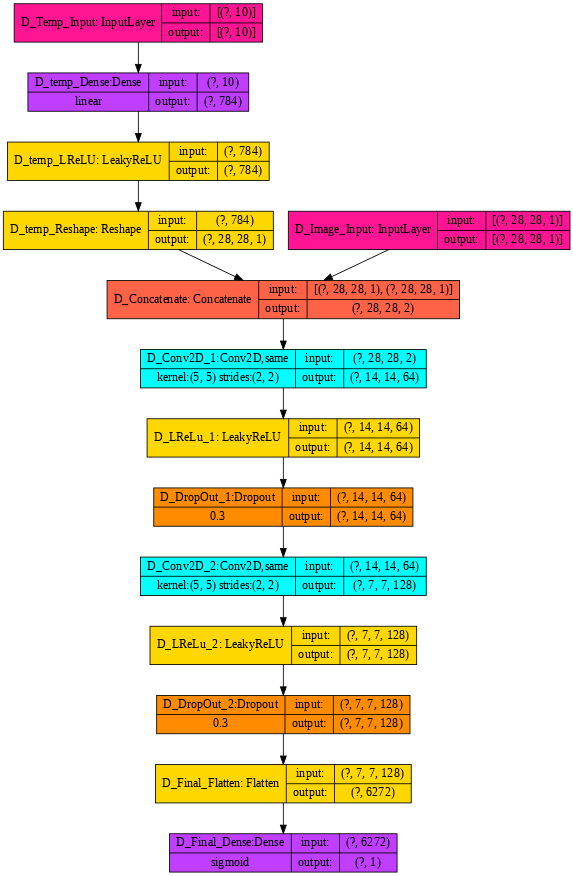

In [17]:
def get_discriminator_model():

    temp_input = layers.Input(shape=(NUM_TEMP_CLASSES,), name="D_Temp_Input")

    t = layers.Dense(28*28, name="D_temp_Dense")(temp_input)
    t = layers.LeakyReLU(name="D_temp_LReLU")(t)
    t = layers.Reshape(IMG_SHAPE, name="D_temp_Reshape")(t)

    img_input = layers.Input(shape=IMG_SHAPE, name="D_Image_Input")
    x = layers.Concatenate(name="D_Concatenate")([t, img_input])

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', 
                      input_shape=IMG_SHAPE, name="D_Conv2D_1")(x)
    x = layers.LeakyReLU(name="D_LReLu_1")(x)
    x = layers.Dropout(0.3, name="D_DropOut_1")(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), 
                      padding='same', name="D_Conv2D_2")(x)
    x = layers.LeakyReLU(name="D_LReLu_2")(x)
    x = layers.Dropout(0.3, name="D_DropOut_2")(x)

    x = layers.Flatten(name="D_Final_Flatten")(x)
    x = layers.Dense(1, name="D_Final_Dense", activation="sigmoid")(x)

    model = keras.models.Model([img_input, temp_input], x, name="discriminator")
    return model

d_model = get_discriminator_model()
plot_model(d_model, 
  dpi=60, color=True, style=1, to_file="d_model.png", show_layer_names=True)

Definisco il generatore, che prende in input il vettore latente (di dimensione 128) e la classe di temperatura come one-hot.

2440512


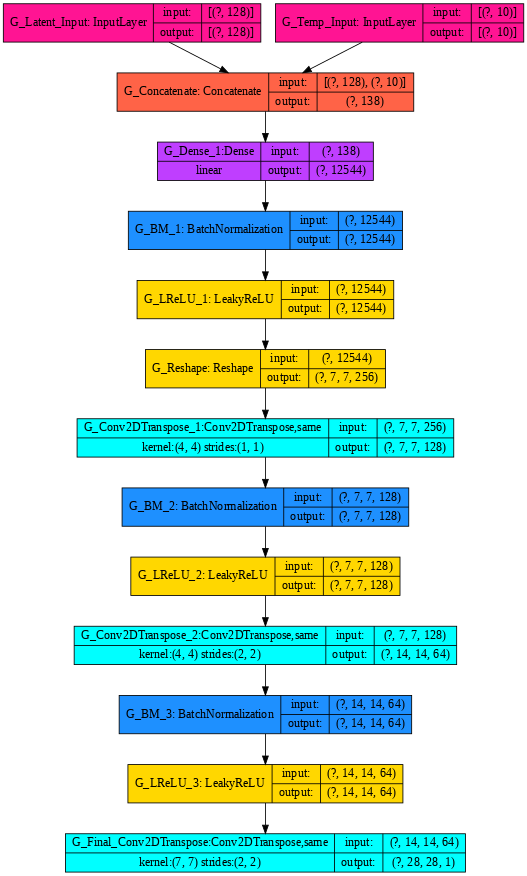

In [45]:
def get_generator_model():

    temp_input = layers.Input(shape=(NUM_TEMP_CLASSES,), name="G_Temp_Input")

    latent_vector = layers.Input(shape=(LATENT_DIM,), name="G_Latent_Input")

    x = layers.Concatenate(name="G_Concatenate")([latent_vector, temp_input])

    x = layers.Dense(7*7*256, use_bias=False, 
                     input_shape=(2*LATENT_DIM,), name="G_Dense_1")(x)
    x = layers.BatchNormalization(name="G_BM_1")(x)
    x = layers.LeakyReLU(name="G_LReLU_1")(x)

    x = layers.Reshape((7, 7, 256), name="G_Reshape")(x)
    
    x = layers.Conv2DTranspose(128, (4, 4), strides=(1, 1), padding='same', 
                               use_bias=False, name="G_Conv2DTranspose_1")(x)
    x = layers.BatchNormalization(name="G_BM_2")(x)
    x = layers.LeakyReLU(name="G_LReLU_2")(x)

    x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', 
                               use_bias=False, name="G_Conv2DTranspose_2")(x)
    x = layers.BatchNormalization(name="G_BM_3")(x)
    x = layers.LeakyReLU(name="G_LReLU_3")(x)

    x = layers.Conv2DTranspose(1, (7, 7), strides=(2, 2), padding='same',
       use_bias=False, activation=tf.tanh, name="G_Final_Conv2DTranspose")(x)

    model = keras.models.Model([temp_input, latent_vector], x, name="generator")
    return model

g_model = get_generator_model()
print(g_model.count_params())
plot_model(g_model, 
  dpi=60, color=True, style=1, to_file="g_model.png", show_layer_names=True)

Definisco ed alleno il regressore, che prende in input una configurazione e ne restituisce la classe di temperatura come one-hot.

In [0]:
def get_regressor_model():
  #modello da https://github.com/raeubaen/ml/blob/master/NB_CNN_LC3_2020.ipynb
  inputs = keras.Input(shape=(28,28,1))

  data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip()
  ], name='DataAugm')

  activation = "relu"

  x = data_augmentation(inputs)

  layer_with_activation = lambda name, x: \
      keras.layers.ReLU(name=name)(x)

  ks = 2
  f1 = 64
  x = keras.layers.Conv2D(f1, kernel_size=(ks,ks), name='Conv_1')(x)
  x = layer_with_activation(f'{activation}_1', x)
  x = keras.layers.MaxPooling2D((2,2), name='MaxPool_1')(x)
  x = keras.layers.Conv2D(f1, kernel_size=(ks,ks), name='Conv_2')(x)
  x = layer_with_activation(f'{activation}_2', x)
  x = keras.layers.MaxPooling2D((2,2), name='MaxPool_2')(x)

  x = keras.layers.Conv2D(f1, kernel_size=(ks,ks), name='Conv_3')(x)
  x = layer_with_activation(f'{activation}_3', x)

  x = keras.layers.Flatten(name='Flatten')(x)

  dense_n = 64
  x = keras.layers.Dense(dense_n, name='Dense_1')(x)
  x = layer_with_activation(f'{activation}_dense_1', x)
  x = keras.layers.Dense(dense_n, name='Dense_2')(x)
  x = layer_with_activation(f'{activation}_dense_2', x)
  x = keras.layers.Dense(dense_n, name='Dense_3')(x)
  x = layer_with_activation(f'{activation}_dense_3', x)
  outputs = keras.layers.Dense(NUM_TEMP_CLASSES, name='Output', activation="softmax")(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  
  model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=8e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
  return model

r_model = get_regressor_model()
cbk = [keras.callbacks.ModelCheckpoint(
           'r.hdf5', save_best_only=True, monitor='val_accuracy', mode='max'
           )]

out = train_test_split(conf, one_hot_temp, test_size=0.1)
train_conf, test_conf, train_one_hot_temp, test_one_hot_temp = out
r_model.fit(train_conf, train_one_hot_temp, 
            epochs=30, validation_split=0.1, callbacks=cbk)

In [10]:
r_model = keras.models.load_model("r.hdf5")
r_model.evaluate(test_conf, test_one_hot_temp)

32/32 [==============================] - 0s 3ms/step - loss: 0.7956 - accuracy: 0.6220


[0.7955880165100098, 0.621999979019165]

Definisco un modello Keras custom, con un subclassing da `keras.Model`.
In particolare distinguo tre modalità di allenamento in base all'input dato al discriminatore
*   A: (immagini reali, temperature reali) -> target 1, (immagini fake, temperature usate per generarle)-> target 0

*   B: (immagini reali, temperature reali) -> target 1, (immagini reali, temperature random)-> target 0, (immagini fake, temperature usate per generarle) -> target 0

*   C: (immagini reali, temperature reali) -> target 1, (immagini reali, temperature random)-> target 0, (immagini fake, temperature ottenute dal regressore sulle immagini fake)-> target 0

In [0]:
# Modello DCGAN: implementiamo un keras.Model custom
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, regressor, latent_dim, mode=None):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.regressor = regressor
        self.latent_dim = latent_dim
        self.mode = mode

    # funzione per la compilazione
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, train_batch):
        if isinstance(train_batch, tuple): #verifica che l'input isa una python tuple (numpy tensor)
            real_images, real_classes = train_batch

        # 1) campiona un batch di punti random nello spazio latente: z
        batch_size = tf.shape(real_images)[0]
        rand_classes = tf.one_hot(
            tf.random.uniform(
                shape=(batch_size,), 
                maxval=NUM_TEMP_CLASSES, 
                dtype=tf.int32
            ),
            NUM_TEMP_CLASSES,
        )
        rand_latent = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 2) usa il generatore per creare dai vettori latenti immagini fake: immagine = G(z)
        generated_images = self.generator([rand_classes, rand_latent])
        
        # 3) determina la temperatura delle immagini generate grazie alla rete ausiliaria

        if self.mode == "A":
            # 4) combina le immagini fake con quelle reali 
            combined_images = tf.concat([
                            real_images, generated_images,# real_images,
            ], axis=0)

            combined_classes = tf.concat([
                            real_classes, rand_classes,# rand_classes,
            ], axis=0)

            # 5) assegna le label corrette (fae vs reale)
            labels = tf.concat([
                tf.ones((batch_size, 1)),  #immagini reali, temperature reali
                tf.zeros((batch_size, 1)), #immagini generate, temperature corrispondenti
                #tf.zeros((batch_size, 1)), #immagini reali, temperature no
            ], axis=0)

        if self.mode == "B":
            generated_classes = self.regressor(generated_images)

            # 4) combina le immagini fake con quelle reali 
            combined_images = tf.concat([
                             real_images, generated_images, real_images,
            ], axis=0)

            combined_classes = tf.concat([
                             real_classes, rand_classes, rand_classes,
            ], axis=0)

            # 5) assegna le label corrette (fae vs reale)
            labels = tf.concat([
                tf.ones((batch_size, 1)),  #immagini reali, temperature reali
                tf.zeros((batch_size, 1)), #immagini generate, temperature corrispondenti
                tf.zeros((batch_size, 1)), #immagini reali, temperature no
            ], axis=0)

        if self.mode == "C":
            generated_classes = self.regressor(generated_images)
            # 4) combina le immagini fake con quelle reali 
            combined_images = tf.concat([
                             real_images, generated_images, real_images,
            ], axis=0)

            combined_classes = tf.concat([
                              real_classes, generated_classes, rand_classes,
            ], axis=0)

            # 5) assegna le label corrette (fae vs reale)
            labels = tf.concat([
                tf.ones((batch_size, 1)),  #immagini reali, temperature reali
                tf.zeros((batch_size, 1)), #immagini generate, temperature corrispondenti
                tf.zeros((batch_size, 1)), #immagini reali, temperature no
            ], axis=0)

        # 6) Trucco per diminuire la probabilità di collasso della rete (si aggiunge un po' di rumore random alle label) 
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # 7) Training del discriminatore D
        with tf.GradientTape() as tape: #autograd
            predictions = self.discriminator(
                [combined_images, combined_classes]) #predizione = D(immagini)
            d_loss = self.loss_fn(labels, predictions) #calcolo loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights) #backprop
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights) #aggiornamento pesi
        )

        # 8) crea un vettore di label corrispondenti a tutte immagii reali
        misleading_labels = tf.ones((batch_size, 1))

        # 9) Training del generatore (non si devono aggiornare ovviamente i pesi del discriminatore)
        with tf.GradientTape() as tape:
            generated_images = self.generator([rand_classes, rand_latent])
            predictions = self.discriminator([generated_images, rand_classes]) #predizione = D(G(z))
            g_loss = self.loss_fn(misleading_labels, predictions) #calcolo loss
        grads = tape.gradient(g_loss, self.generator.trainable_weights) #backprop
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights)) #aggiornamento pesi

        return {"d_loss": d_loss, "g_loss": g_loss}

Definisco una callback custom, con un subclassing di `keras.callbacks.Callback`,
che alla fine di ogni epoca salva come immagine un set di configurazioni generate (una per ciascuna classe di temperatura).

In [0]:
# custom callback to save generated images peridoically during training
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=11, latent_dim=128, norma=1.0):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.norma = norma

    def on_epoch_end(self, epoch, logs=None):
        classes = tf.one_hot(range(self.num_img), NUM_TEMP_CLASSES)
        latent = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator([classes, latent])
        generated_images = generated_images * self.norma
        fig, axs = plt.subplots(1, self.num_img, figsize=(18, 5))
        for i in range(self.num_img):
            img = generated_images[i].numpy().reshape(28, 28)
            axs[i].imshow(img)
        fig.savefig(f"{epoch}.png")
        plt.close()

Come ottimizzatore utilizzo ADAM, con $\eta=0.0002,\,\beta=0.5$ (best-practice per le GAN).

In [0]:
# Training della GAN

# Ottimizzatori di G e D
# learning_rate=0.0002, beta_1=0.5 are recommened
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
# Loss function
gan_loss = keras.losses.BinaryCrossentropy(from_logits=True)

# Callbacks
cbk = GANMonitor(num_img=NUM_TEMP_CLASSES, latent_dim=LATENT_DIM, norma=255)

Eseguo il training della GAN, con le tre modalità A, B e C in sequenza (300 epoche ciascuna).

In [0]:
for mode in ["A", "B", "C"]:
  # Istanziamento modello
  gan = DCGAN(discriminator=d_model, generator=g_model, regressor=r_model, 
              latent_dim=LATENT_DIM, mode=mode)

  # Compilazione
  gan.compile(d_optimizer=discriminator_optimizer,
      g_optimizer=generator_optimizer,
      loss_fn=gan_loss,
  )

  gan.fit(dataset, epochs=300, batch_size=64, callbacks=[cbk]) 

Per garantire maggiore variabilità al generatore, aggiungo un layer finale che inverte tutti gli spin con probabilità 1/2.

In [0]:
class RandomInvertLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
      super().__init__(**kwargs)

    def call(self, inputs):
      samples = 2*tf.random.categorical(tf.math.log([[0.5, 0.5]]), tf.shape(inputs)[0])-1

      # Reshape b with dim_array and perform elementwise multiplication with 
      # broadcasting along the singleton dimensions for the final output
      samples = tf.reshape(samples, [-1,  1,  1,  1])
      return inputs * tf.cast(samples, "float32")

In [0]:
temp_input = layers.Input(shape=(NUM_TEMP_CLASSES,), name="G_Temp_Input")

latent_vector = layers.Input(shape=(LATENT_DIM,), name="G_Latent_Input")

x = g_model([temp_input, latent_vector])
x = RandomInvertLayer()(x)

final_gen = keras.models.Model([temp_input, latent_vector], x)

Visualizzo varie configurazioni generate, variando la classe di temperatura da sinistra verso destra. 

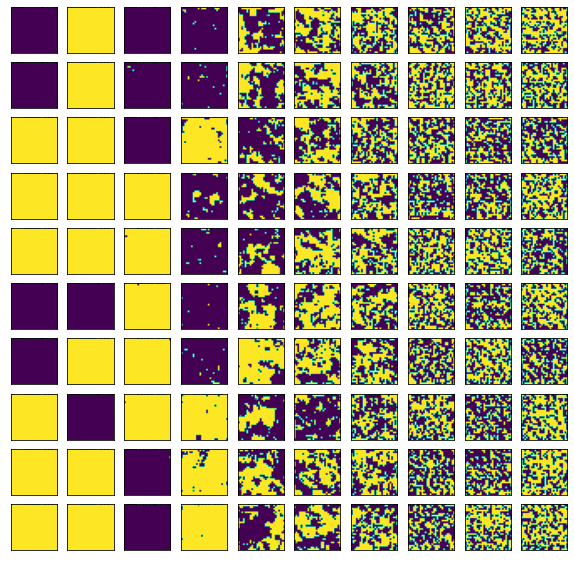

In [35]:
classes = tf.one_hot(range(NUM_TEMP_CLASSES), NUM_TEMP_CLASSES)

fig, axs = plt.subplots(10, NUM_TEMP_CLASSES, figsize=(10, 10))
for i in range(10):
  for j in range(NUM_TEMP_CLASSES):
    latent = tf.random.normal(shape=(NUM_TEMP_CLASSES, LATENT_DIM))
    generated_images = final_gen([classes, latent])
    img = generated_images[j].numpy().reshape(28, 28)
    axs[i][j].imshow(img)
    axs[i][j].set(xticks=[], yticks=[])

Genero 100 configurazioni con temperature casuali.

In [0]:
randint = np.random.randint(0, high=10, size=10000)
classes = tf.one_hot(randint, NUM_TEMP_CLASSES)

latent = tf.random.normal(shape=(10000, LATENT_DIM))
generated_images = final_gen([classes, latent]).numpy().round()

Plotto i valori della magnetizzazione dei campioni generati in funzione della classe di temperatura.

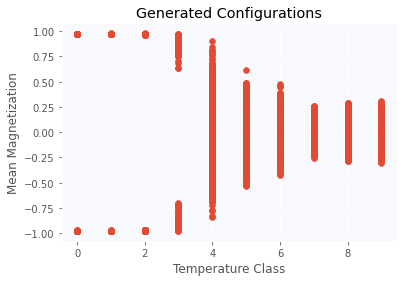

In [32]:
magn = np.mean(generated_images, axis=(1, 2))
plt.scatter(randint, magn)
plt.xlabel("Temperature Class")
plt.ylabel("Mean Magnetization")
plt.title("Generated Configurations")
plt.show()

Confronto con la distribuzione originale.

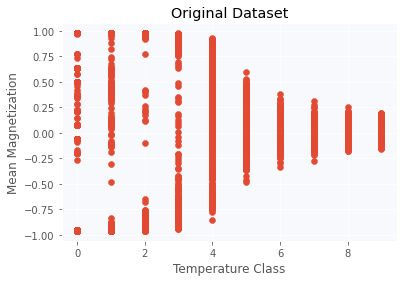

In [21]:
orig_magn = np.mean(conf, axis=(1,2))
plt.scatter(label, orig_magn)
plt.xlabel("Temperature Class")
plt.ylabel("Mean Magnetization")
plt.title("Original Dataset")
plt.show()

Si vede che la GAN genera configurazioni anche migliori del dataset di partenza, poiché non ha acquisito i suoi difetti a basse temperature.

Visualizzo i due istogrammi della magnetizzazione a confronto.

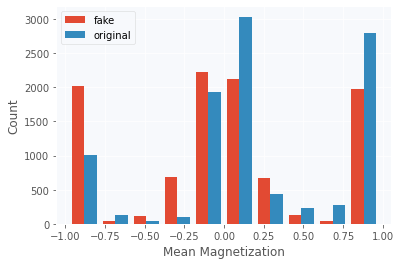

In [24]:
plt.close()
plt.hist([magn.reshape(-1), orig_magn.reshape(-1)], label=['fake', 'original'])
plt.legend(loc='upper left')
plt.ylabel("Count")
plt.xlabel("Mean Magnetization")
plt.show()